In [119]:
import essentia.standard as estd
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist, squareform, euclidean
import statistics as stats
from scipy.signal import find_peaks


#### Get audio vector and inital tempo estimation

In [84]:
path = '../audio/money-pink-floyd-hd-studio-version_02.mp3'
loader = estd.AudioLoader(filename=path)
downmixer = estd.MonoMixer()
tempAudioInput, fs, numb_channels, md5, bit_rate, codec = loader()
audioInput = downmixer(tempAudioInput, numb_channels)
tempo_estimation_algo = estd.PercivalBpmEstimator(sampleRate=int(fs))
bpm = tempo_estimation_algo(audioInput)
print(bpm)

126.82131958007812


#### Compute spectrogram and 2-band energy

In [85]:
# Dynamic Programming Python implementation of Min Cost Path
R = 30
C = 30
def minCost(cost, m, n): 
  
    # Instead of following line, we can use int tc[m+1][n+1] or 
    # dynamically allocate memory to save space. The following 
    # line is used to keep te program simple and make it working 
    # on all compilers.
    tc = [[0 for x in range(C)] for x in range(R)] 
  
    tc[0][0] = cost[0][0] 
  
    # Initialize first column of total cost(tc) array 
    for i in range(1, m+1): 
        tc[i][0] = tc[i-1][0] + cost[i][0] 
  
    # Initialize first row of tc array 
    for j in range(1, n+1): 
        tc[0][j] = tc[0][j-1] + cost[0][j] 
  
    # Construct rest of the tc array 
    for i in range(1, m+1): 
        for j in range(1, n+1): 
            tc[i][j] = min(tc[i-1][j-1], tc[i-1][j], tc[i][j-1]) + cost[i][j] 
  
    return tc[m][n] 

In [104]:
## var init
frame_size = 1024
hop_size = 512
fft_size = 1024

## get necessary Essentia algorithms
window_algo = estd.Windowing(normalized=True, size = frame_size, type = 'hann')
fft_algo = estd.FFT(size = fft_size)
cutoff_bin = int(5000*1024/fs)

spectrogram = []
db_spectrogram = []
print('Frame Size:', frame_size)
print('FFT Size:', fft_size)

for index, frame in enumerate(estd.FrameGenerator(audioInput, frameSize = frame_size, hopSize = hop_size, startFromZero = True)):
    ## spectrogram
    windowed_frame = window_algo(frame)
    mX = abs(fft_algo(windowed_frame))
    mX[mX<np.finfo(float).eps] = np.finfo(float).eps    ## if zeros add epsilon to handle log
    dbX = 20 * np.log10(mX[:cutoff_bin+1])
    spectrogram.append(np.array(mX[:cutoff_bin+1]))
    db_spectrogram.append(np.array(dbX))
    
spectrogram = np.array(spectrogram)
db_spectrogram = np.array(db_spectrogram)
print('Spectrogram done. Size is (axis1, axis2):', spectrogram.shape)

Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (1037, 117)


#### Plot Spectrogram (for visual feedback only)

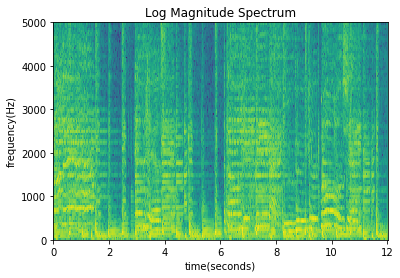

In [105]:
timeAxSec=np.arange(db_spectrogram.shape[0])*hop_size/float(fs)
freqAx_normalized=np.arange(db_spectrogram.shape[1])/float(fft_size)    #Normalized frequency axis
freqAxHz=float(fs)*freqAx_normalized

plt.pcolormesh(timeAxSec,freqAxHz,np.transpose(db_spectrogram))
plt.xlim([0,timeAxSec[-1]])
plt.ylim([0,freqAxHz[-1]])
plt.title('Log Magnitude Spectrum')
plt.ylabel('frequency(Hz)')
plt.xlabel('time(seconds)')
plt.show()

In [106]:
# beat estimation
beatTracker = estd.BeatTrackerDegara()
beats = beatTracker(audioInput)
beats_frames = [int(bf) for bf in (beats * fs / hop_size)]
#print(beats)
print(len(beats))
#print(beats_frames)

24


In [122]:
# for i in range(len(beats)-1):
#     dur_beats.append(beats[i+1] - beats[i])
#     pc8_dur_beats.append(dur_beats[i] * 0.08)

# avDur = np.average(dur_beats)
# avDurInFrames = int(avDur * fs / hop_size)
# avDur8 = np.average(pc8_dur_beats)
# avDur8InFrames = int(avDur8 * fs / hop_size)
# print(avDurInFrames)
# print(avDur8InFrames)

# framePosBeat = []
beats_neighbour_spect = {}
beats_spect = []
i = 0

while i <= len(beats_frames)-1:
    if i != len(beats_frames)-1:
        beat_duration = beats_frames[i+1] - beats_frames[i]
    duration_8_percent = int(beat_duration*0.08)
    beats_neighbour_spect[beats_frames[i]] = spectrogram[beats_frames[i]-duration_8_percent:beats_frames[i]+duration_8_percent]
    beats_spect.append(spectrogram[beats_frames[i]])
    i += 1

ASM_dict = {}
for beat_index,beat_x in enumerate(beats_spect):
    ASM_dict[beat_index] = {}
    for beat_y in beats_neighbour_spect:
        temp_ASM = []
        for neighbour in beats_neighbour_spect[beat_y]:    
            temp_ASM.append(euclidean(neighbour, beat_x))
        ASM_dict[beat_index][beat_y] = temp_ASM

In [123]:
print(len(beats_frames))

24


In [126]:
ASM_dict

{0: {44: [0.17170868813991547,
   0.17079049348831177,
   0.12615656852722168,
   0.0,
   0.17546449601650238,
   0.13147112727165222],
  89: [0.2104424238204956,
   0.20838601887226105,
   0.19938531517982483,
   0.20218312740325928,
   0.2030569165945053,
   0.3223958909511566],
  132: [0.26724761724472046,
   0.26679322123527527,
   0.26553457975387573,
   0.32788968086242676,
   0.42834827303886414,
   0.36559808254241943],
  174: [0.2766374349594116,
   0.37512698769569397,
   0.37383776903152466,
   0.28415700793266296,
   0.27617302536964417,
   0.30038151144981384],
  214: [0.29326173663139343,
   0.28865984082221985,
   0.26414960622787476,
   0.4382578134536743,
   0.35686153173446655,
   0.3102993667125702],
  256: [0.28485938906669617,
   0.31598109006881714,
   0.3682146370410919,
   0.39019250869750977,
   0.3415565490722656,
   0.30978935956954956],
  297: [0.35009920597076416,
   0.36744701862335205,
   0.29813313484191895,
   0.33186566829681396,
   0.3747391998767853,

In [124]:
BSM = []
counti = 0 
for beat_frame_i, ASM_beat_dict in ASM_dict.items():
    BSM.append([])
    for beat_frame_j, ASM in ASM_beat_dict.items():
        BSM[counti].append(minCost(ASM, ASM.shape[0]-1, ASM.shape[1]-1))
    counti += 1

AttributeError: 'list' object has no attribute 'shape'

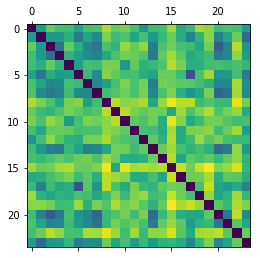

In [110]:
plt.matshow(BSM)

In [111]:
len(BSM)

24

In [112]:
d = []
d_inverted = []
for i, beat in enumerate(BSM):
    d.append(stats.mean(list(np.diagonal(BSM, i))))
    d_inverted.append(-d[i])
d_inverted += max([abs(item) for item in d])

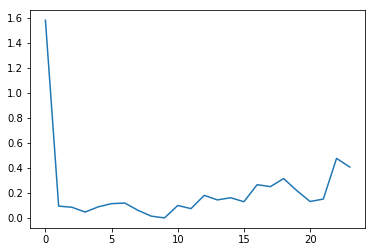

In [113]:
plt.plot(d_inverted)

In [114]:
d_peaks = find_peaks(d_inverted)[0]
for i in d_peaks:
    d_inverted[i] *= 2

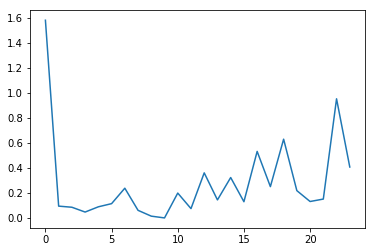

In [115]:
plt.plot(d_inverted)

In [116]:
d_inverted

array([ 1.57901688,  0.09413144,  0.0852807 ,  0.04686321,  0.08875222,
        0.11399205,  0.23732006,  0.06054728,  0.01410069,  0.        ,
        0.19845645,  0.07437225,  0.35986043,  0.14383645,  0.32260123,
        0.12931206,  0.53119156,  0.24989995,  0.62881678,  0.21787645,
        0.1310908 ,  0.1505893 ,  0.95150543,  0.40645716])

In [117]:
bar_candidates = list(range(2,12))
lt = math.floor(len(beats)/11)
tc = []
for c in bar_candidates:
    t_sum = 0
    for p in range(1, lt+1):
        t_sum += (d_inverted[p*c]/(1-((p-1)/lt)))
    tc.append(t_sum)

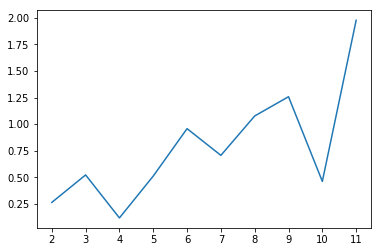

In [118]:
plt.xticks(list(range(10)), bar_candidates)
plt.plot(tc)